# Modeling and Evaluation Notebook

### Objectives
- Fit and evaluate a classification model if a guest had breakfast or not

### Inputs
- outputs/datasets/collection/BreakfastSurvey.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

### Outputs

- Train set (features and target)
- Test set (features and target)
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline
- Feature importance plot


---

## Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Guest-Survey-Analysis-to-Improve-Hotel-Breakfast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Comfirm the current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/Guest-Survey-Analysis-to-Improve-Hotel-Breakfast'

---

## Load data

In [5]:
import numpy as np
import pandas as pd

df = (pd.read_csv("outputs/datasets/collection/BreakfastSurvey.csv")
)

print(df.shape)
df.head(3)

(27332, 8)


,appearance,breakfast,service,staff,variety,price,taste,hotel
0,1,"Yes, next time not",7,3,1,2,1,3
1,1,No,5,3,1,2,1,2
2,7,"Yes, next time not",7,4,5,8,7,7


## ML pipeline for Data Cleaning and Feature Engineering

Label Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["breakfast"] = le.fit_transform(df["breakfast"])

Create datacleaning pipeline

In [7]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("BoxCox", vt.BoxCoxTransformer(['appearance', 'staff'])),
        ("yeo_johnson", vt.YeoJohnsonTransformer(['price', 'taste', "hotel"])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
            method="spearman", threshold=0.8, selection_method="variance",    
        ))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('BoxCox',
                 BoxCoxTransformer(variables=['appearance', 'staff'])),
                ('yeo_johnson',
                 YeoJohnsonTransformer(variables=['price', 'taste', 'hotel'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance'))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [8]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["breakfast"], axis=1),
    df["breakfast"],
    test_size = 0.2,
    random_state = 0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(21865, 7) (21865,) (5467, 7) (5467,)


## Handle Target Imbalance

In [11]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21865, 5) (21865,) (5467, 5) (5467,)


Check Train Set Target distribution

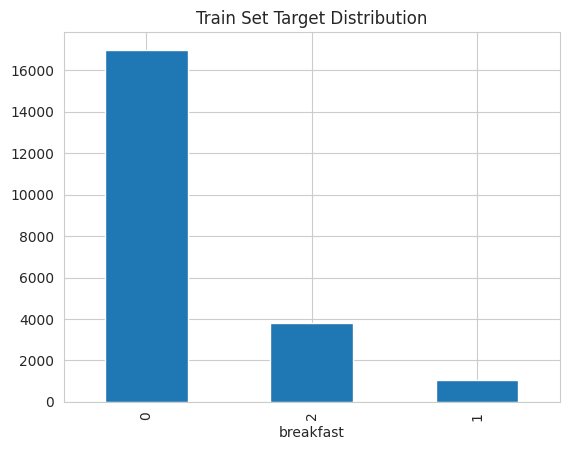

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use Synthetic Minority Oversampling Technique to balance Train Set target

(50988, 5) (50988,) (5467, 5) (5467,)


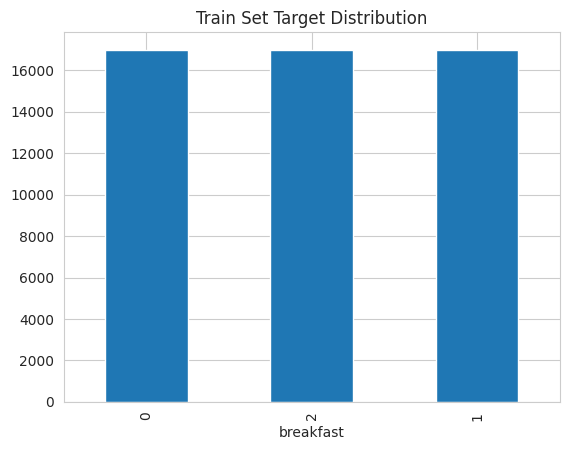

In [13]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='not majority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [15]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier

In [16]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, average="macro"),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check the results

In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
4,GradientBoostingClassifier,0.819167,0.836844,0.845935,0.009388
1,XGBClassifier,0.803767,0.827429,0.836717,0.012036
2,DecisionTreeClassifier,0.806317,0.819761,0.825763,0.006886
3,RandomForestClassifier,0.806415,0.819682,0.825959,0.006865
5,ExtraTreesClassifier,0.806513,0.819643,0.825861,0.006808
6,AdaBoostClassifier,0.780555,0.814171,0.831331,0.018651
0,LogisticRegression,0.655015,0.661411,0.665392,0.003505


### Find the best hyperparameter

Define model and parameters, for extensive search

In [ ]:
models_search = {
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "XGBClassifier":XGBClassifier(random_state=0)
}

params_search = {
    "GradientBoostingClassifier":{
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    },
    "DecisionTreeClassifier":{ 
        'model__max_depth': [3,10,None],
    },
    "XGBClassifier":{
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV - Binary Classifier

In [19]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, average="macro"),
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
0,GradientBoostingClassifier,0.819167,0.836844,0.845935,0.009388,0.1,3
10,DecisionTreeClassifier,0.807102,0.832763,0.84113,0.012971,NaN,10
4,GradientBoostingClassifier,0.807886,0.831253,0.840149,0.011791,0.01,10
7,GradientBoostingClassifier,0.808867,0.830822,0.838776,0.011074,0.001,10
12,XGBClassifier,0.817108,0.830705,0.836521,0.007165,0.1,3
14,XGBClassifier,0.806121,0.830704,0.840149,0.012479,0.1,None
17,XGBClassifier,0.813676,0.830058,0.835834,0.008276,0.01,None
16,XGBClassifier,0.805729,0.828919,0.837305,0.011677,0.01,10
19,XGBClassifier,0.805631,0.828174,0.836521,0.011526,0.001,10
13,XGBClassifier,0.806317,0.8279,0.835932,0.010929,0.1,10


Get best model name programmatically

In [21]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingClassifier'

Parameters for best model

In [22]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 3}

Define the best clf pipeline

In [23]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

## Assess feature importance

- With the current model, we can assess with .features_importances_

* These are the 2 most important features in descending order. The model was trained on them: 
['service', 'hotel']


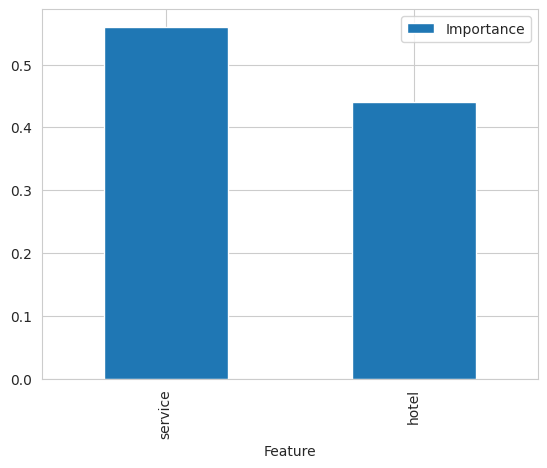

In [24]:
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [25]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [26]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ["No","Yes","Again"] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                 Actual No Actual Yes Actual Again
Prediction No        16151        143         2495
Prediction Yes           7      13796         1729
Prediction Again       838       3057        12772


---  Classification Report  ---
              precision    recall  f1-score   support

          No       0.86      0.95      0.90     16996
         Yes       0.89      0.81      0.85     16996
       Again       0.77      0.75      0.76     16996

    accuracy                           0.84     50988
   macro avg       0.84      0.84      0.84     50988
weighted avg       0.84      0.84      0.84     50988
 

#### Test Set ####

---  Confusion Matrix  ---
                 Actual No Actual Yes Actual Again
Prediction No         4038          4          200
Prediction Yes           0        185           71
Prediction Again       199         63          707


---  Classification Report  ---
              precision    recall  f1-score  

## Refit pipeline and Resampling

### Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [27]:
best_features

['service', 'hotel']

Label Encoding

In [28]:
le = LabelEncoder()
df["breakfast"] = le.fit_transform(df["breakfast"])

In [29]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("BoxCox", vt.BoxCoxTransformer(['appearance', 'staff'])),
        ("yeo_johnson", vt.YeoJohnsonTransformer(['price', 'taste', "hotel"])),
    ])

    return pipeline_base

### Rewrite ML Pipeline for Modelling

In [30]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

### Split Train Test Set, considering only with best features

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['breakfast'], axis=1),
    df['breakfast'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21865, 7) (21865,) (5467, 7) (5467,)


We filter only the most important variables

In [32]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(21865, 2) (21865,) (5467, 2) (5467,)


,service,hotel
9735,5,3
8494,5,2
14618,6,3


### Handle Target Imbalance

In [33]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21865, 2) (21865,) (5467, 2) (5467,)


Check Train Set Target distribution

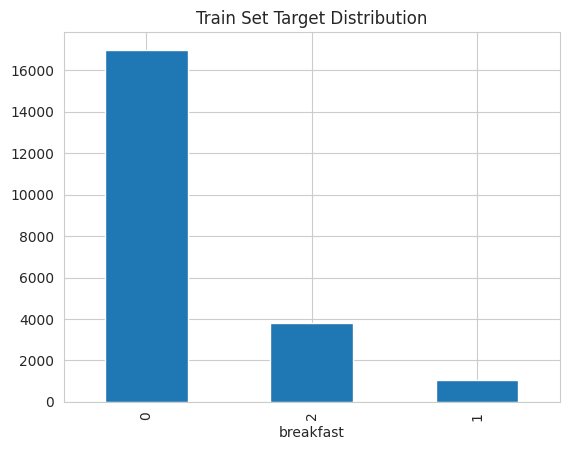

In [34]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [35]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='not majority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50988, 2) (50988,) (5467, 2) (5467,)


Check Train Set Target distribution after SMOTE

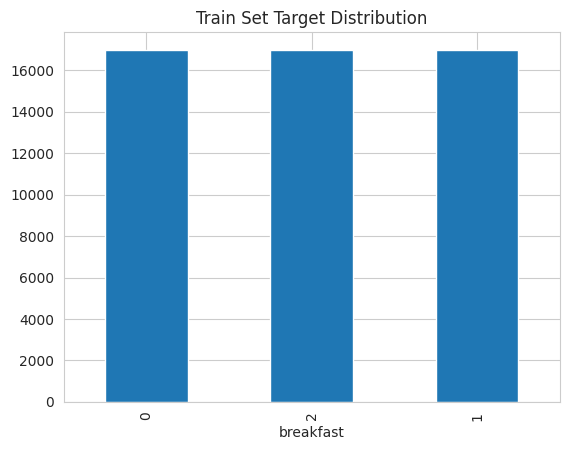

In [36]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

### Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

In [37]:
models_search = {
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
}

And the best parameters from the last GridCV search

In [38]:
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 3}

Hyperparameter values

In [39]:
params_search = {'GradientBoostingClassifier':  {
    'model__learning_rate': [0.1],
    'model__max_depth': [3]},
}
params_search

{'GradientBoostingClassifier': {'model__learning_rate': [0.1],
  'model__max_depth': [3]}}

GridSearch CV

In [40]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, average="macro"),
                 n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [41]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
0,GradientBoostingClassifier,0.808669,0.812073,0.813769,0.001887,0.1,3


Define the best clf pipeline

In [42]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

### Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['service', 'hotel']


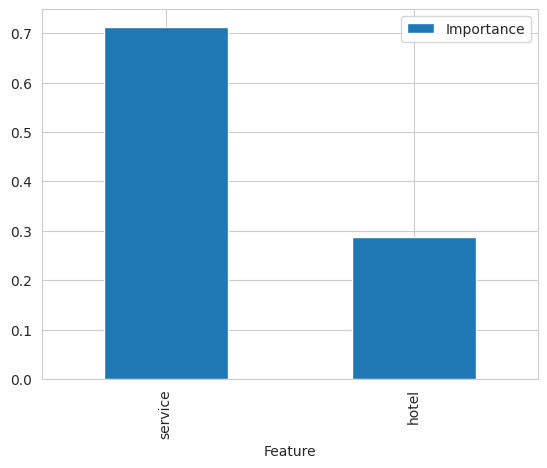

In [43]:
best_features = X_train.columns

df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [44]:
clf_performance(X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    pipeline=pipeline_clf,
    label_map= ["No","Yes","Again"] 
)

#### Train Set #### 

---  Confusion Matrix  ---
                 Actual No Actual Yes Actual Again
Prediction No        15377        256         2616
Prediction Yes           7      13092         1421
Prediction Again      1612       3648        12959


---  Classification Report  ---
              precision    recall  f1-score   support

          No       0.84      0.90      0.87     16996
         Yes       0.90      0.77      0.83     16996
       Again       0.71      0.76      0.74     16996

    accuracy                           0.81     50988
   macro avg       0.82      0.81      0.81     50988
weighted avg       0.82      0.81      0.81     50988
 

#### Test Set ####

---  Confusion Matrix  ---
                 Actual No Actual Yes Actual Again
Prediction No         3837          3          150
Prediction Yes           0        189           71
Prediction Again       400         60          757


---  Classification Report  ---
              precision    recall  f1-score  

## Push files to Repo

Generate the following files
- Train set
- Test set
- Data cleaning
- Modeling pipeline
- Features importance plot

In [45]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_breakfast/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_breakfast/v1'


### Train Set

In [46]:
print(X_train.shape)
X_train.head()

(50988, 2)


,service,hotel
0,5,3
1,5,2
2,6,3
3,5,3
4,6,2


In [47]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [48]:
y_train.head(5)

0    0
1    0
2    0
3    0
4    0
Name: breakfast, dtype: int64

In [49]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

In [50]:
print(X_test.shape)
X_test.head()

(5467, 2)


,service,hotel
4984,5,5
10644,3,3
19389,5,3
26830,5,3
1801,6,5


In [51]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [52]:
y_test.head(5)

4984     0
10644    2
19389    0
26830    0
1801     2
Name: breakfast, dtype: int64

In [53]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

Pipeline responsible for Data Cleaning and Feature Engineering

In [54]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_breakfast/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

Pipeline responsible for Feature Scaling, and Model

In [55]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

In [56]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_breakfast/v1/clf_pipeline_model.pkl']

### Feature Importance plot

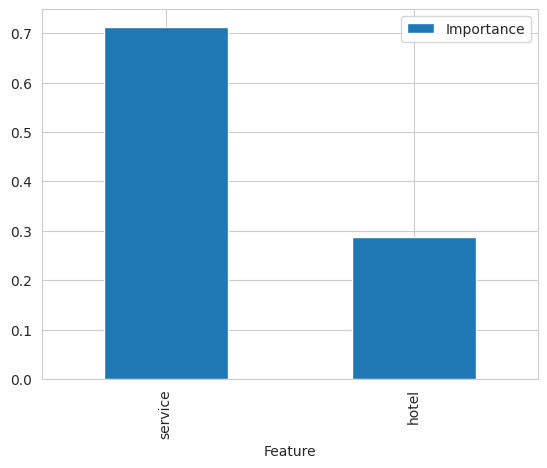

In [57]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

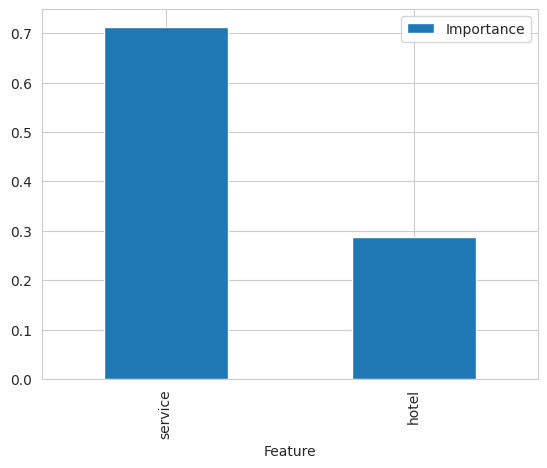

In [58]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')